# Цель

Настройка числа кластеров в алгоритме K-Means. Elbow и Silhouette метод.
Выбрать любой датасет для задач кластеризации.

In [144]:
import time
import re
# from __future__ import print_function
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.metrics import accuracy_score


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score

import xgboost as xgb
# import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Датасет

По представленные данным можно произвести сегментацию клиентов для определения маркетинговой стратегии. 
Образец набора данных суммирует поведение примерно 9000 активных держателей кредитных карт за последние 6 месяцев. 
Датасет содержит 18 поведенческими перизнаков.

- CUST_ID : Идентификатор держателя кредитной карты (категориальная)
- BALANCE : Сумма баланса для совершения покупок (BALANCE_FREQUENCY: как часто обновляется баланс, оценка от 0 до 1 (1 = часто обновляется, 0 = не часто обновляется)
- PURCHASES : Сумма покупок, сделанных со счета
- ONEOFF_PURCHASES : Максимальная сумма покупки за один раз
- INSTALLMENTS_PURCHASES : Сумма покупки в рассрочку
- CASH_ADVANCE : Наличные, заранее предоставленные пользователем
- PURCHASES_FREQUENCY : Как часто совершаются покупки, баллы от 0 до 1 (1 = часто покупаемые, 0 = не часто покупаемые)
- ONEOFFPURCHASESFREQUENCY : Как часто покупки происходят за один раз (1 = часто покупаемые, 0 = не часто покупаемые)
- PURCHASESINSTALLMENTSFREQUENCY : Как часто совершаются покупки в рассрочку (1 = часто совершается, 0 = не часто совершается)
- CASHADVANCEFREQUENCY : Как часто наличными заранее выплачиваются
- CASHADVANCETRX : Количество транзакций, совершенных с помощью «Cash in Advanced»
- PURCHASES_TRX : Количество совершенных покупок
- CREDIT_LIMIT : Лимит кредитной карты для пользователя
- PAYMENTS : Сумма платежа, выполненного пользователем
- MINIMUM_PAYMENTS : Минимальная сумма платежей, сделанных пользователем
- PRCFULLPAYMENT : Процент полной оплаты, оплаченный пользователем
- TENURE : Срок действия кредитной карты для пользователя

Выборка представлена единственным файлом, в котором не содержится целевая переменная.

In [145]:
df = pd.read_csv('data/CC GENERAL.csv')
df.head(8)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.90,0.82,95.40,0.00,95.40,0.00,0.17,0.00,0.08,0.00,0,2,1000.00,201.80,139.51,0.00,12
1,C10002,3202.47,0.91,0.00,0.00,0.00,6442.95,0.00,0.00,0.00,0.25,4,0,7000.00,4103.03,1072.34,0.22,12
2,C10003,2495.15,1.00,773.17,773.17,0.00,0.00,1.00,1.00,0.00,0.00,0,12,7500.00,622.07,627.28,0.00,12
3,C10004,1666.67,0.64,1499.00,1499.00,0.00,205.79,0.08,0.08,0.00,0.08,1,1,7500.00,0.00,nan,0.00,12
4,C10005,817.71,1.00,16.00,16.00,0.00,0.00,0.08,0.08,0.00,0.00,0,1,1200.00,678.33,244.79,0.00,12
5,C10006,1809.83,1.00,1333.28,0.00,1333.28,0.00,0.67,0.00,0.58,0.00,0,8,1800.00,1400.06,2407.25,0.00,12
6,C10007,627.26,1.00,7091.01,6402.63,688.38,0.00,1.00,1.00,1.00,0.00,0,64,13500.00,6354.31,198.07,1.00,12
7,C10008,1823.65,1.00,436.20,0.00,436.20,0.00,1.00,0.00,1.00,0.00,0,12,2300.00,679.07,532.03,0.00,12


# EDA

## 1. Анализ признаков

In [146]:
shape = df.shape
print("Кол-во наблюдений: {}, кол-во признаков: {} ".format(shape[0],shape[1]))

Кол-во наблюдений: 8950, кол-во признаков: 18 


Выведем кол-во пропущенных значений:

In [147]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Посмотрим какой процент пропущенных данных в признаках `CREDIT_LIMIT и MINIMUM_PAYMENTS`.

In [154]:
for future in ['CREDIT_LIMIT','MINIMUM_PAYMENTS']:
    missing_percent = round(df[future].isnull().sum()/ shape[0],4)
    print("Признак {} содержит {}% пропущенных значений.".format(future,missing_percent))

Признак CREDIT_LIMIT содержит 0.0001% пропущенных значений.
Признак MINIMUM_PAYMENTS содержит 0.035% пропущенных значений.


Пропущенные значения можно удалить.

In [155]:
df2 = df.dropna().copy(deep=True)

In [162]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8636 non-null object
BALANCE                             8636 non-null float64
BALANCE_FREQUENCY                   8636 non-null float64
PURCHASES                           8636 non-null float64
ONEOFF_PURCHASES                    8636 non-null float64
INSTALLMENTS_PURCHASES              8636 non-null float64
CASH_ADVANCE                        8636 non-null float64
PURCHASES_FREQUENCY                 8636 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8636 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8636 non-null float64
CASH_ADVANCE_FREQUENCY              8636 non-null float64
CASH_ADVANCE_TRX                    8636 non-null int64
PURCHASES_TRX                       8636 non-null int64
CREDIT_LIMIT                        8636 non-null float64
PAYMENTS                            8636 non-null float64
MINIMUM_PAYMENTS            

In [163]:
df2.drop(columns=['CUST_ID'], axis=1, inplace=True)

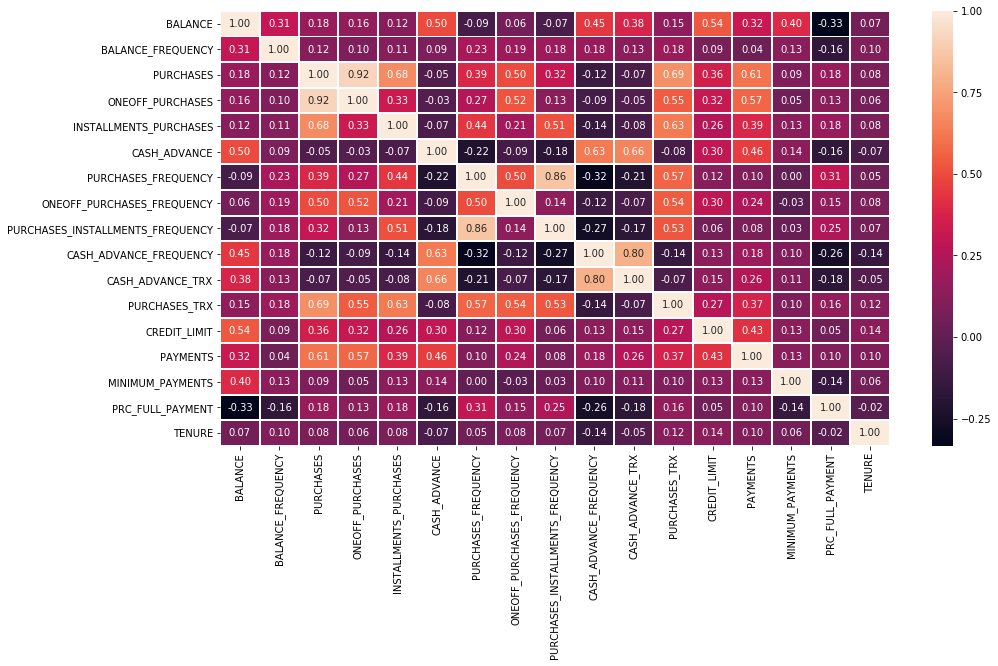

In [170]:
sns.heatmap(df2.corr(method='pearson'), annot=True, fmt='.2f', linewidths=1)

Из матрицы корелляции по Пирсону видна высокая корреляция у следующих признаков:
    
    ONEOFF_PURCHASES - PURCHASES = 0.92
    PURCHASES_INSTALLMENTS_FREQUENCY - URCHASES_FREQUENCY = 0.86
    CASH_ADVANCE_TRX - CASH_ADVANCE_FREQUENCY = 0.80
    
Для улучшения результатов кластеризации удалим из каждой пары один признак. Так мы не можем отранжировать признаки по влиянию на целевую переменную, то возьмем любые: `ONEOFF_PURCHASES`,`PURCHASES_INSTALLMENTS_FREQUENCY`, `CASH_ADVANCE_TRX`.

In [201]:
df3 = df2.drop(columns=['ONEOFF_PURCHASES','PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_TRX'], axis=1)

Сразу произведем шкалирование.

In [207]:
df4 = df3.copy(deep=True)
sc = StandardScaler()
df4 = sc.fit_transform(df3)

Посмотрим на распределение перизнаков.

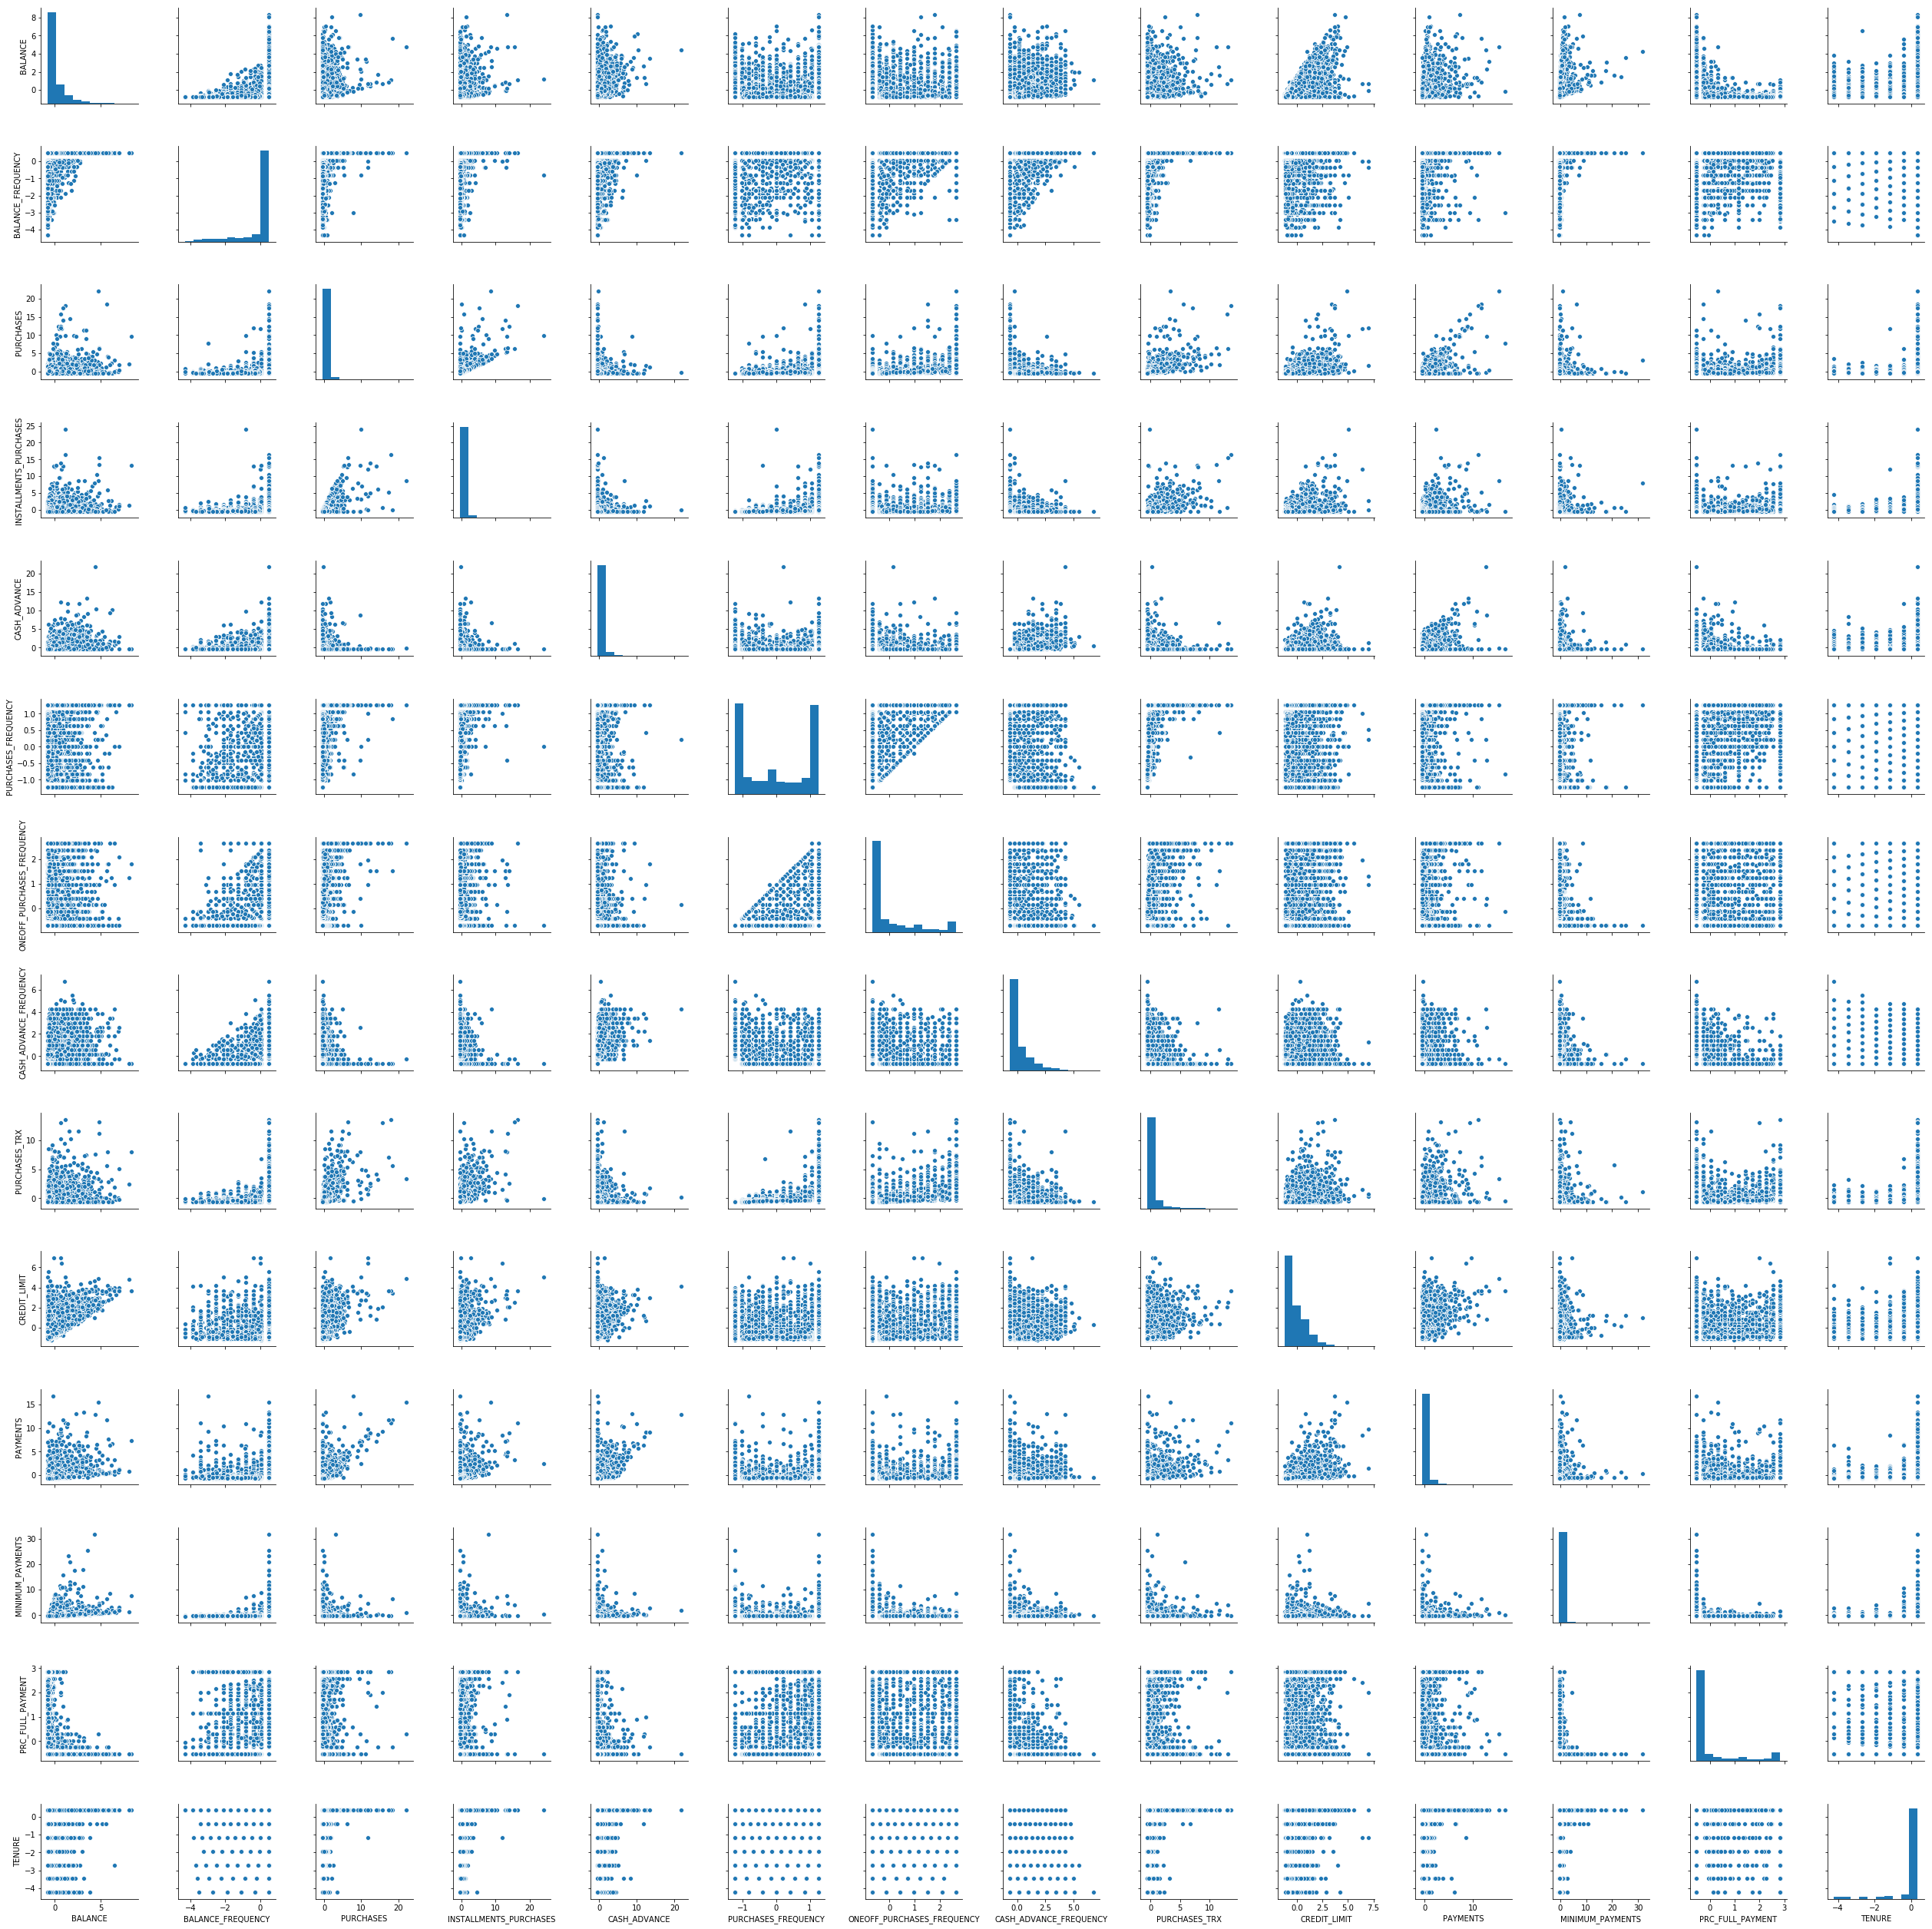

In [210]:
df4 = pd.DataFrame(df4, columns=df3.columns)
sns.pairplot(df4);

Выраженных линеныйх зависимостей не наблюдается.

## 2. t-SNE анализ

Попробуем через `TSNE` увидеть возможную структуру в данных.

In [211]:
%%time
tsne_result = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(df2)

CPU times: user 2min 28s, sys: 7.64 s, total: 2min 36s
Wall time: 1min 23s


In [215]:
tsne_result

array([[ 36.243908,   7.578085],
       [-14.216901,  17.832542],
       [-17.14724 ,  11.165979],
       ...,
       [ 37.89333 ,   9.427092],
       [ 33.076153, -17.046757],
       [ 18.724756,   3.145678]], dtype=float32)

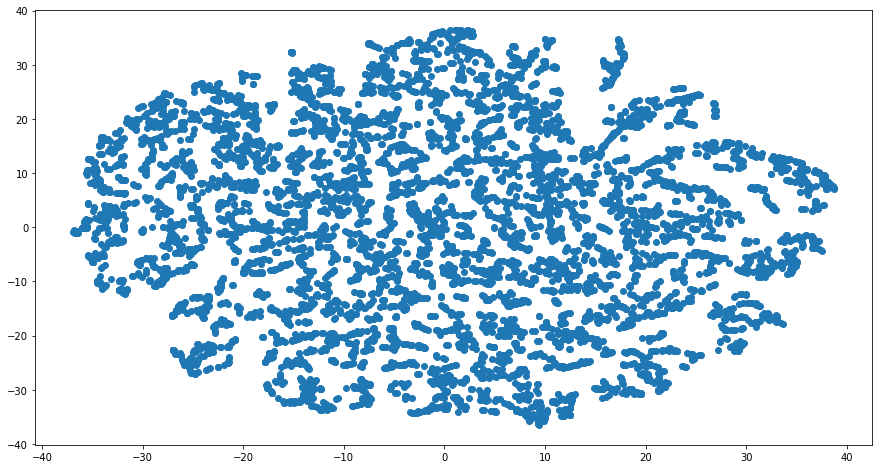

In [214]:
plt.scatter(tsne_result[:,0], tsne_result[:, 1]);

По форме графика можно седить, что данные обладают некоторой структурой.

## 3. Нахождение оптимального количества кластеров

Попробуем найти оптимальное количество кластеров c помощью K-Means

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

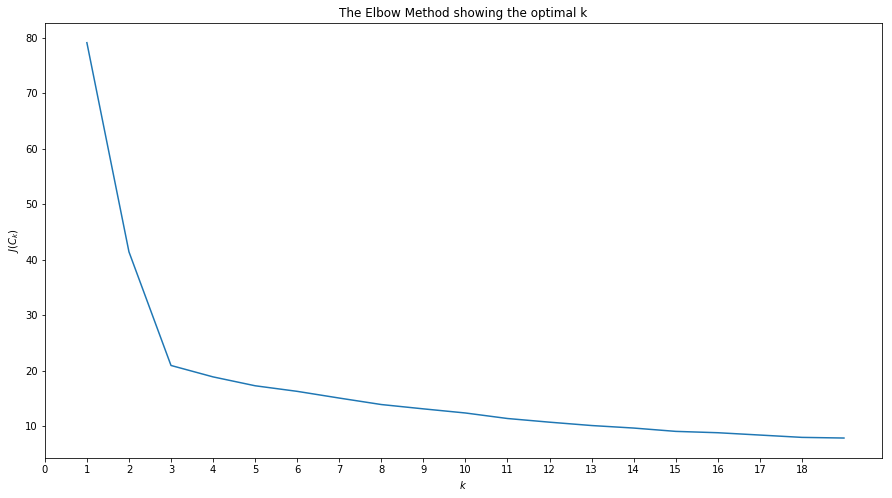

In [244]:
inertia = []
k = range(1, 20)
for cluster in k:
    km = KMeans(n_clusters=cluster).fit(df4)
    km.fit(df)
    inertia.append(np.sqrt(km.inertia_))

plt.plot(k, inertia)
plt.xticks(np.arange(0, 19, step=1))

plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.title('The Elbow Method showing the optimal k')

Функционал $J(C_k)$ замедляет падение при $k = 3$. Таким образом оптимальное количество кластеров `3`.

Построим также график по метрике `Silhouette`.

Text(0.5, 1.0, 'The Silhouette metric showing the optimal k')

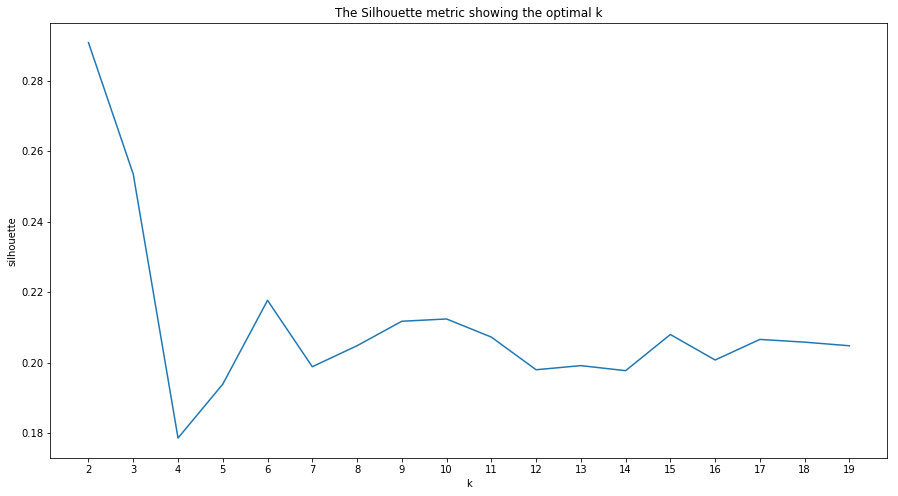

In [256]:
from sklearn.metrics import silhouette_score
inertia = []
k = range(2, 20)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(df4)
    km.fit(df4)
    inertia.append(silhouette_score(df4, km.labels_))
    
plt.plot(k, inertia)
plt.xlabel('k')
plt.xticks(k) #np.arange(0, 19, step=1)
plt.ylabel('silhouette')
plt.title('The Silhouette metric showing the optimal k')

Silhouette максимален при количестве кластеров равным 2.

## Визуализация 3 кластеров

Визуализируем 3 кластера в трехмерном пространстве.

[[8.82071449e+02 8.76459680e-01 6.22459894e+02 3.23174676e+02
  2.99594630e+02 5.01864907e+02 4.74416469e-01 1.58394714e-01
  3.56850380e-01 1.08680578e-01 2.29914258e+00 1.09653858e+01
  2.77050232e+03 1.03812333e+03 5.73262047e+02 1.64558420e-01
  1.14571292e+01]
 [3.46015404e+03 9.46676458e-01 1.60039297e+03 9.96151652e+02
  6.04565419e+02 2.15263287e+03 5.42261350e-01 3.18153777e-01
  3.88932947e-01 2.14771123e-01 5.85921231e+00 2.24363966e+01
  9.05097535e+03 2.96362998e+03 1.59694302e+03 1.33940943e-01
  1.17369851e+01]
 [4.87916214e+03 9.17611326e-01 1.08536936e+04 7.65950163e+03
  3.19436248e+03 5.19215982e+03 7.57564000e-01 6.03537062e-01
  6.08805682e-01 2.28296233e-01 9.27131783e+00 8.68604651e+01
  1.24848837e+04 1.80309572e+04 2.52779839e+03 3.37066930e-01
  1.18372093e+01]]


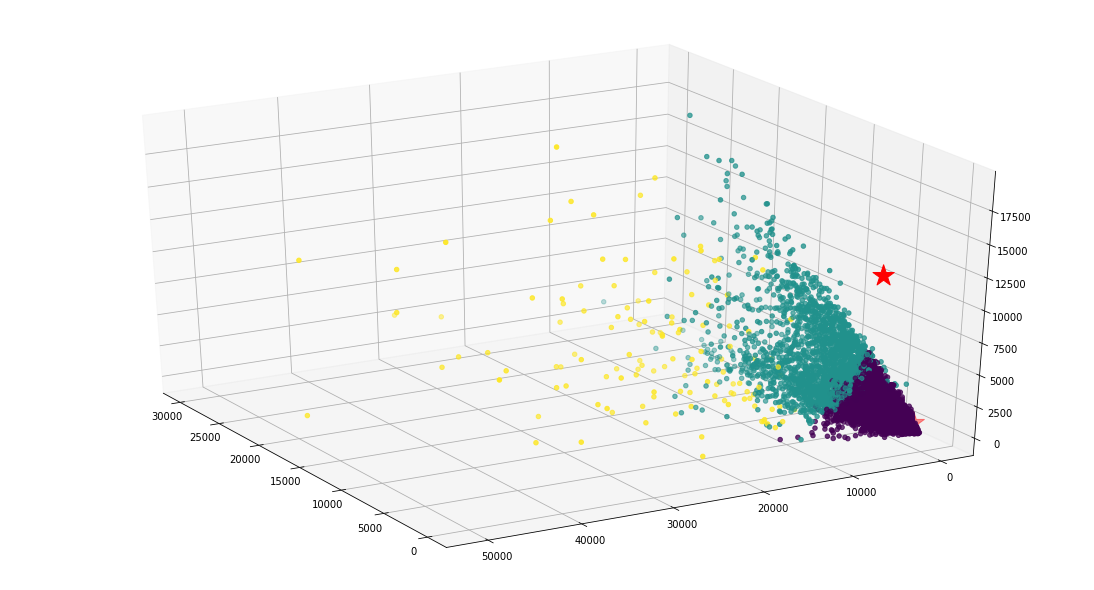

In [264]:
kmeans3 = KMeans(n_clusters=3).fit(df2)
centroids = kmeans.cluster_centers_
print(centroids)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df2['CREDIT_LIMIT'], df2['PAYMENTS'], df2['BALANCE'],c= kmeans3.labels_.astype(float))
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', c='red', s=500)
ax.view_init(30, 150)
plt.show()

Посмотрим как будут выглядеть 3 кластера на t-SNE.

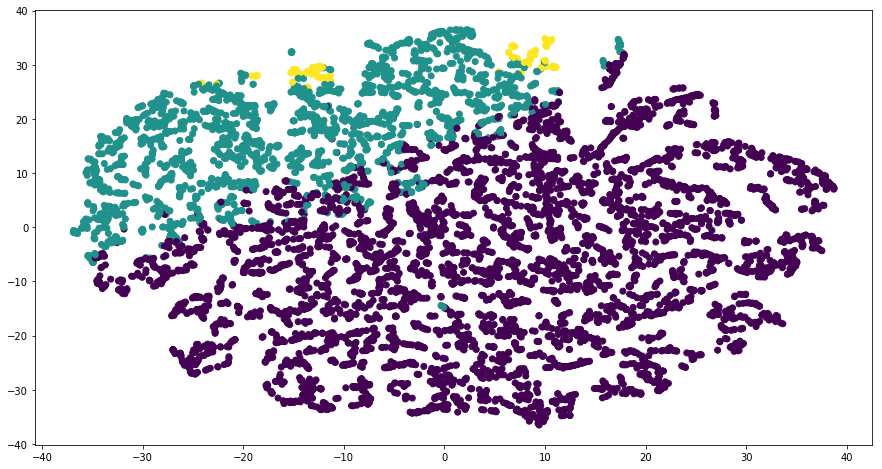

In [267]:
plt.scatter(tsne_result[:,0], tsne_result[:, 1],c=kmeans3.labels_.astype(float));

## Визуализация 2 кластеров

[[8.82071449e+02 8.76459680e-01 6.22459894e+02 3.23174676e+02
  2.99594630e+02 5.01864907e+02 4.74416469e-01 1.58394714e-01
  3.56850380e-01 1.08680578e-01 2.29914258e+00 1.09653858e+01
  2.77050232e+03 1.03812333e+03 5.73262047e+02 1.64558420e-01
  1.14571292e+01]
 [3.46015404e+03 9.46676458e-01 1.60039297e+03 9.96151652e+02
  6.04565419e+02 2.15263287e+03 5.42261350e-01 3.18153777e-01
  3.88932947e-01 2.14771123e-01 5.85921231e+00 2.24363966e+01
  9.05097535e+03 2.96362998e+03 1.59694302e+03 1.33940943e-01
  1.17369851e+01]
 [4.87916214e+03 9.17611326e-01 1.08536936e+04 7.65950163e+03
  3.19436248e+03 5.19215982e+03 7.57564000e-01 6.03537062e-01
  6.08805682e-01 2.28296233e-01 9.27131783e+00 8.68604651e+01
  1.24848837e+04 1.80309572e+04 2.52779839e+03 3.37066930e-01
  1.18372093e+01]]


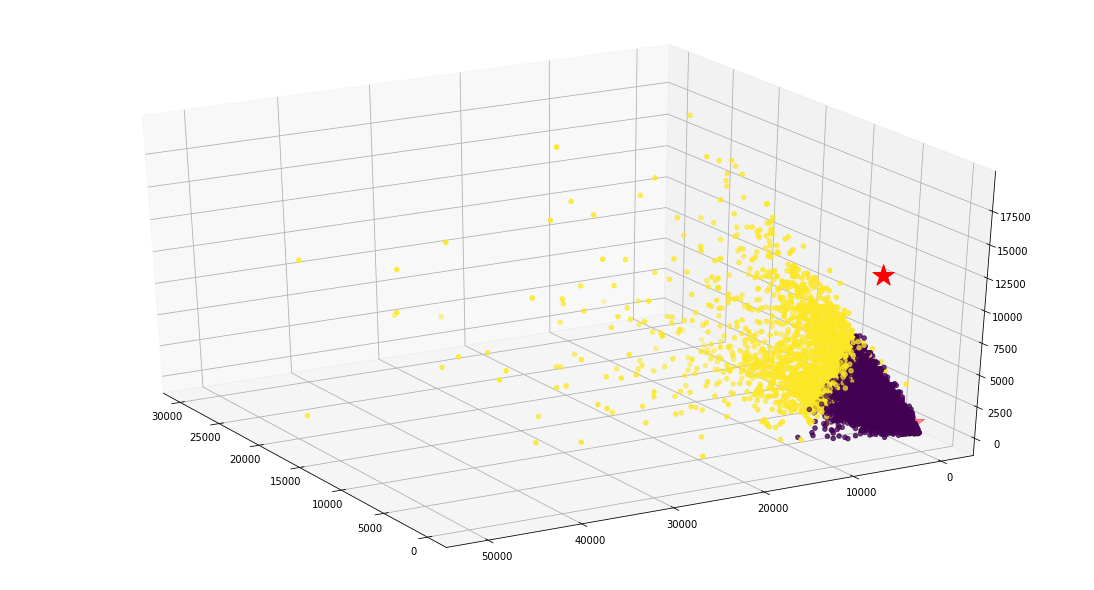

In [265]:
kmeans2 = KMeans(n_clusters=2).fit(df2)
centroids = kmeans.cluster_centers_
print(centroids)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df2['CREDIT_LIMIT'], df2['PAYMENTS'], df2['BALANCE'],c= kmeans2.labels_.astype(float))
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', c='red', s=500)
ax.view_init(30, 150)
plt.show()

Посмотрим как будут выглядеть 2 кластера на t-SNE.

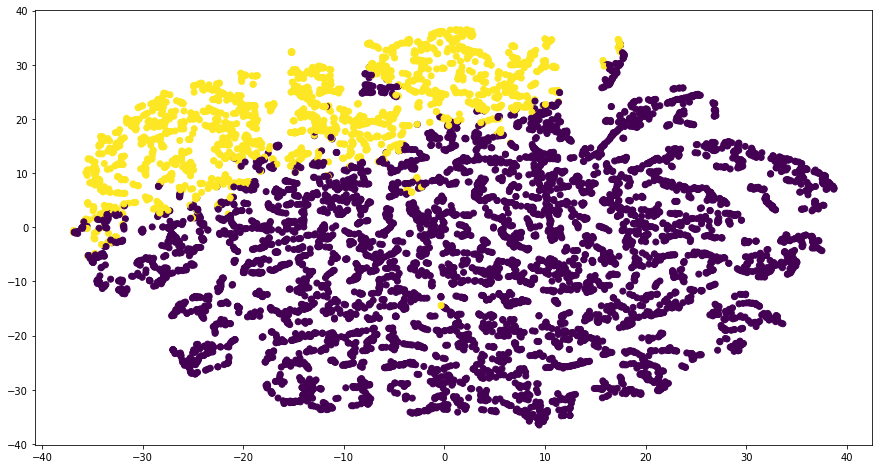

In [268]:
plt.scatter(tsne_result[:,0], tsne_result[:, 1],c=kmeans2.labels_.astype(float));

# Выводы

Для датасета с использование алгоритма K-Means было определено оптимальное количество кластеров с применением оценок методами `Elbow` и `Silhouette`.

Наиболее оптимальное количество кластеров равняется 2.